# Coursera Capstone Project - Opening a Mexican Restaurant in Hong Kong

### Import Libraries

In [265]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!pip install geopy
from geopy.geocoders import Nominatim

!pip install folium
import folium

from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import json
import requests

print('Libraries Imported!')

Libraries Imported!


### Download and Clean Dataset

In [266]:
#Download Hong Kong District Offices and Sub-offices Dataset
!wget -q -O 'hongkong_data.csv' https://geodata.gov.hk/gs/download-dataset/bdc1924a-5391-4964-ab15-b731f0757d07/CSV?fullset=1

#Read data into panda
hk_data = pd.read_csv('hongkong_data.csv')

In [267]:
#Select relevant features only
hk_neighborhoods = hk_data[['Facility Name','Address','District','Latitude','Longitude']]
hk_neighborhoods = hk_neighborhoods.rename(columns={"Facility Name":"Office Name"})
hk_neighborhoods.head()

,Office Name,Address,District,Latitude,Longitude
0,Wan Chai District Office - Sub Office,"G/F., 2 O'Brien Road, Wan Chai, Hong Kong.",WAN CHAI,22.27737,114.17320
1,Wan Chai District Office,"21/F, Southorn Centre, 130 Hennessy Road, Wan ...",WAN CHAI,22.27726,114.17283
2,Eastern District Office - Chai Wan Sub-office,"New Jade Garden, Level One, 233 Chai Wan Road,...",EASTERN,22.26391,114.23635
3,Eastern District Office - Causeway Bay Sub-office,"1/F, Causeway Bay Community Centre, 7 Fook Yum...",EASTERN,22.28845,114.19106
4,Eastern District Office - Shau Kei Wan Sub-office,"G/F, Eastern Law Courts Building, 29 Tai On St...",EASTERN,22.28419,114.22429


##### Reserved in case dataset available

In [268]:
#Download Hong Kong District Offices and Sub-offices Dataset
#!wget -q -O 'hongkong_data.json' https://geodata.gov.hk/gs/download-dataset/bdc1924a-5391-4964-ab15-b731f0757d07/GeoJSON?fullset=1
#with open('hongkong_data.json') as json_data:
#    hongkong_data = json.load(json_data)
    
#hk_data_features = hongkong_data['features']
#hk_data_features

#Create new dataframe for Hong Kong
#column_names = ['Office Name', 'Address', 'District', 'Latitude', 'Longitude'] 
#hk_neighborhoods = pd.DataFrame(columns=column_names)

#Append useful data from json file into the newly created dataframe
#for data in hk_data_features:
#    office = data['properties']['Facility_Name'] 
#    address = data['properties']['Address']
#    district = data['properties']['District']
#    latitude = data ['properties']['Latitude']
#    longitude = data ['properties']['Longitude']
    
#    hk_neighborhoods = hk_neighborhoods.append({'Office Name': office,
#                                                'Address': address,
#                                                'District': district,
#                                                'Latitude': latitude,
#                                                'Longitude': longitude
#                                               }, ignore_index=True)
    
#print('Number of district offices / sub-offices: ', hk_neighborhoods.shape[0])

#hk_neighborhoods.head()

### Visualization of the 36 District Offices Across 18 Districts in Hong Kong

In [269]:
#Import visualization libraries
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

#Hong Kong's Geographical coordintes
address = 'Kowloon, Hong Kong'
geolocator = Nominatim(user_agent = 'my_application')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Kowloon, Hong Kong are {}, {}.'.format(latitude, longitude))

#Create a Map of Hong Kong
map_hongkong = folium.Map(location=[latitude,longitude], zoom_start = 10.5)

#Add Markers to Visualize the 36 District Offices
for lat, lng, office_name, district in zip(hk_neighborhoods['Latitude'], hk_neighborhoods['Longitude'], hk_neighborhoods['Office Name'], hk_neighborhoods['District']):
    label = '{}, {}'.format(office_name, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#FFFFFF',
        fill_opacity= 0.7,
        parse_html=False
    ).add_to(map_hongkong)

map_hongkong

The geograpical coordinate of Kowloon, Hong Kong are 22.3116452, 114.1767885.


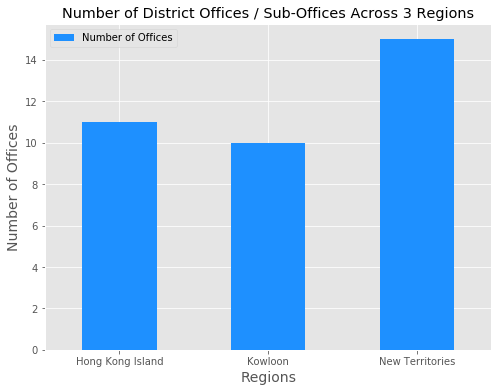

In [270]:
#Number of District offices / sub-offices in each region
hk_island = []
kowloon = []
new_territories = []

for office in hk_neighborhoods['District']:
    if office == 'CENTRAL AND WESTERN' or office == 'EASTERN' or office == 'SOUTHERN' or office == 'WAN CHAI':
        hk_island.append(office)
    elif office == 'SHAM SHUI PO' or office == 'KOWLOON CITY' or office == 'KWUN TONG' or office == 'WONG TAI SIN' or office == 'YAU TSIM MONG':
        kowloon.append(office)
    else:
        new_territories.append(office)
    
region_count = pd.DataFrame({"Region":['Hong Kong Island', 'Kowloon', 'New Territories'],
                           "Number of Offices":[len(hk_island), len(kowloon), len(new_territories)]})

region_count.set_index('Region', inplace=True)
region_count

region_count.plot(kind='bar', figsize=(8, 6), color='dodgerblue')

plt.xticks(rotation=360, fontsize=10)
plt.title('Number of District Offices / Sub-Offices Across 3 Regions')
plt.ylabel('Number of Offices', fontsize=14)
plt.xlabel('Regions',fontsize=14)

plt.show()

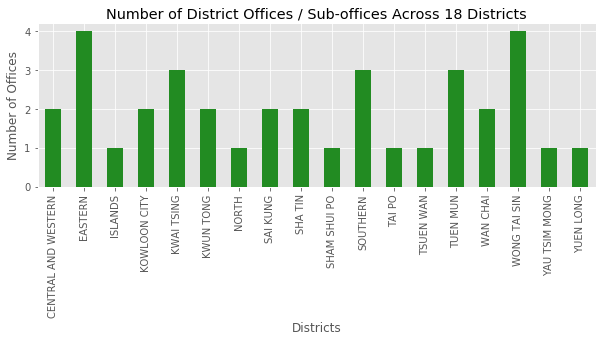

In [271]:
#Number of District offices / sub-offices in each district
district_count = hk_neighborhoods.groupby('District').count()['Office Name']
district_count.plot(kind='bar', figsize=(10, 3), color='forestgreen')

plt.title('Number of District Offices / Sub-offices Across 18 Districts')
plt.xlabel('Districts')
plt.ylabel('Number of Offices')

plt.show()

### Define Foursquare Credential

In [272]:
CLIENT_ID = 'NLKZQFYPHSDFBQRVPRCJRUDLHSK13YQGHXAB4RPUEFHBLRQD' # your Foursquare ID
CLIENT_SECRET = 'IY2FS3433FTQNDSYOKQ2QDG50IYPM1TGIUDSWHH0TAYH2YJQ' # your Foursquare Secret
VERSION = '20180604'

### Number of Mexican Restaurants near Each District Office / Sub-Offices

In [273]:
#Create empty list for number of mexican restaurants
mexican_count = []


for office, lat, lng in zip(hk_neighborhoods['Office Name'], hk_neighborhoods['Latitude'], hk_neighborhoods['Longitude']):
    
    #define url items for each district office
    search_query = 'Mexican'
    radius = 2000
    latitude = lat
    longitude = lng
    LIMIT = 100
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    
    #count number of mexican restaurant in the given district
    counter = 0
    for venue in venues:
        counter = counter + 1
    
    #Append number of mexican restaurant to mexican_count list
    mexican_count.append(counter)
    

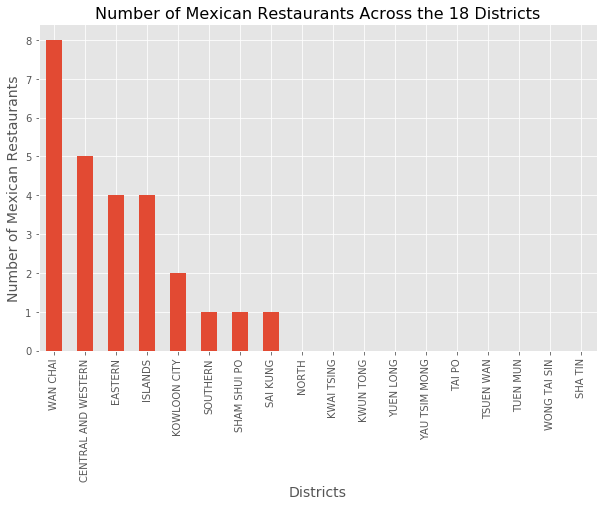

In [274]:
#Add mexican_count list to the hk_neighborhoods dataframe
hk_neighborhoods['# Of Mexican Restaurant'] = mexican_count

#Count number of Mexican Restaurants in Each District
district_mexican = hk_neighborhoods.groupby('District')['# Of Mexican Restaurant'].sum()
district_mexican = district_mexican.sort_values(ascending=False)

#Visualization
district_mexican.plot(kind='bar', figsize=(10,6))

plt.title('Number of Mexican Restaurants Across the 18 Districts', fontsize=16)
plt.xlabel('Districts', fontsize=14)
plt.ylabel('Number of Mexican Restaurants', fontsize = 14)

plt.show()

#### Districts without a mexican restaurant: North, Kwai Tsing, Kwun Tong, Yuen Long, Yau Tsim Mong, Tai Po, Tseun Wan, Tuen Mun, Wong Tai Sin, Sha Tin

### Number of Bars near Each District Office / Sub-Offices

In [275]:
#Create empty list for number of bars
bar_count = []


for office, lat, lng in zip(hk_neighborhoods['Office Name'], hk_neighborhoods['Latitude'], hk_neighborhoods['Longitude']):
    
    #define url items for each district office
    search_query = 'Bar'
    radius = 2000
    latitude = lat
    longitude = lng
    LIMIT = 100
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    
    #count number of bars in the given district
    counter = 0
    for venue in venues:
        counter = counter + 1
    
    #Append number of bars to bar_count list
    bar_count.append(counter)

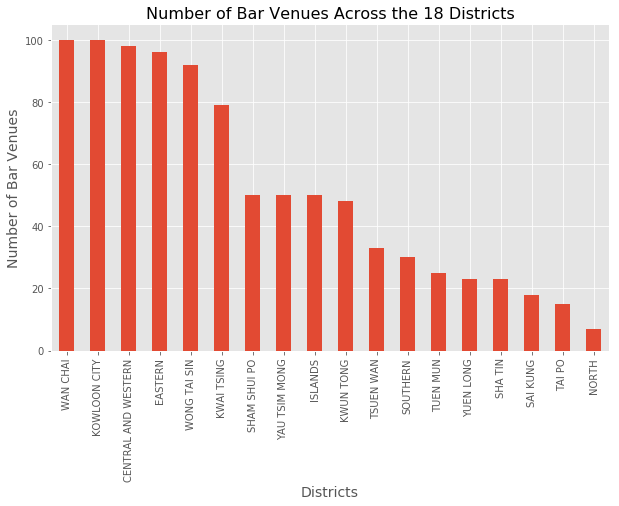

In [276]:
#Add bar_count list to the hk_neighborhoods dataframe
hk_neighborhoods['# Of Bar Venues'] = bar_count

#Count number of Bars in Each District
district_bar = hk_neighborhoods.groupby('District')['# Of Bar Venues'].sum()
district_bar = district_bar.sort_values(ascending=False)

#Visualization
district_bar.plot(kind='bar', figsize=(10,6))

plt.title('Number of Bar Venues Across the 18 Districts', fontsize=16)
plt.xlabel('Districts', fontsize=14)
plt.ylabel('Number of Bar Venues', fontsize = 14)

plt.show()

### Exploring Nearby Venues for Each District Offices / Sub-Offices

In [277]:
#Create a function that gets nearby venues for each district offices / sub offices
def getNearbyVenues(names, latitude, longitude, radius = 2000):
    
    venues_list = []
    LIMIT = 100
    
    for name, lat, lng in zip(names, latitude, longitude):
        
        #Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #Make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        #Returns only relevant info for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Office Name',
                            'Office Latitude',
                            'Office Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    
    print('Nearby Venues Returned!')
    return(nearby_venues)
    

In [278]:
hongkong_venues = getNearbyVenues(names = hk_neighborhoods['Office Name'],
                                 latitude = hk_neighborhoods['Latitude'],
                                 longitude = hk_neighborhoods['Longitude'])


Nearby Venues Returned!


In [279]:
print(hongkong_venues.shape)
#hongkong_venues.groupby('Office Name').count()
hk_neighborhoods

(2925, 7)


,Office Name,Address,District,Latitude,Longitude,# Of Mexican Restaurant,# Of Bar Venues
0,Wan Chai District Office - Sub Office,"G/F., 2 O'Brien Road, Wan Chai, Hong Kong.",WAN CHAI,22.27737,114.17320,4,50
1,Wan Chai District Office,"21/F, Southorn Centre, 130 Hennessy Road, Wan ...",WAN CHAI,22.27726,114.17283,4,50
2,Eastern District Office - Chai Wan Sub-office,"New Jade Garden, Level One, 233 Chai Wan Road,...",EASTERN,22.26391,114.23635,0,4
3,Eastern District Office - Causeway Bay Sub-office,"1/F, Causeway Bay Community Centre, 7 Fook Yum...",EASTERN,22.28845,114.19106,4,50
4,Eastern District Office - Shau Kei Wan Sub-office,"G/F, Eastern Law Courts Building, 29 Tai On St...",EASTERN,22.28419,114.22429,0,21
5,Kwun Tong District Office Shun Lee Sub-office,"3/F., Shun Lee Estate Community Centre, 2 Shun...",KWUN TONG,22.33157,114.22726,0,19
6,Kwun Tong District Office,"21/F, Millennium City 6, 392 Kwun Tong Road, K...",KWUN TONG,22.31330,114.22201,0,29
7,Office of Building Management Liaison Section ...,"11/F, Kennedy Town Community Complex, 12 Rockh...",CENTRAL AND WESTERN,22.28179,114.12914,1,48
8,Tsuen Wan District Office,"1/F, Tsuen Wan Multi-storey Carpark Building, ...",TSUEN WAN,22.37275,114.11860,0,33
9,"Sai Kung Office, Sai Kung District Office","2/F., Sai Kung Government Offices Building, 34...",SAI KUNG,22.38203,114.27244,1,7


### Analyze Each Neighborhood

In [280]:
#One hot encoding
hongkong_onehot = pd.get_dummies(hongkong_venues[['Venue Category']], prefix="", prefix_sep="")

#Add neighborhood column back to dataframe
hongkong_onehot['Office Name'] = hongkong_venues['Office Name']

#Move Office to the first column
fixed_columns = [hongkong_onehot.columns[-1]] + list(hongkong_onehot.columns[:-1])
hongkong_onehot = hongkong_onehot[fixed_columns]

hongkong_onehot.head()


,Office Name,Accessories Store,Airport Service,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Betting Shop,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cruise Ship,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donburi Restaurant,Dumpling Restaurant,Electronics Store,English Restaurant,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Nature Preserve,Neighborhood,New American Restaurant,Non-Profit,Noodle House,Office,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Reservoir,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Snack Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,Wan Chai District Office - Sub Office,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wan Chai District Office - Sub Office,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [281]:
#Group rows by Offices and by taking the mean of the frequency of occurence of each category
hongkong_grouped = hongkong_onehot.groupby('Office Name').mean().reset_index()
hongkong_grouped

,Office Name,Accessories Store,Airport Service,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Betting Shop,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cruise Ship,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donburi Restaurant,Dumpling Restaurant,Electronics Store,English Restaurant,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Nature Preserve,Neighborhood,New American Restaurant,Non-Profit,Noodle House,Office,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Reservoir,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Snack Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,Butterfly/Wu King Sub-office,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.040000,0.00,0.080000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000

In [282]:
#Print top types of venues nearby each offices
num_top_venues = 5
for office in hongkong_grouped['Office Name']:
    print("----"+office+"----")
    temp = hongkong_grouped[hongkong_grouped['Office Name'] == office].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Butterfly/Wu King Sub-office----
                  Venue  Freq
0    Seafood Restaurant  0.24
1  Fast Food Restaurant  0.20
2    Chinese Restaurant  0.08
3         Shopping Mall  0.08
4  Hong Kong Restaurant  0.04


----Central and Western District Office----
                 Venue  Freq
0  Japanese Restaurant  0.09
1          Coffee Shop  0.07
2                 Café  0.06
3                Hotel  0.05
4   Italian Restaurant  0.05


----Eastern District Office----
                 Venue  Freq
0   Chinese Restaurant  0.08
1                 Park  0.07
2          Coffee Shop  0.06
3  Japanese Restaurant  0.06
4   Seafood Restaurant  0.05


----Eastern District Office - Causeway Bay Sub-office----
                 Venue  Freq
0                Hotel  0.11
1   Chinese Restaurant  0.08
2          Coffee Shop  0.06
3         Dessert Shop  0.06
4  Japanese Restaurant  0.05


----Eastern District Office - Chai Wan Sub-office----
                  Venue  Freq
0  Fast Food Restaurant  0.15
1    

In [283]:
#function to sort the venues in descending order
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [284]:
#Create new dataframe and display the top 10 venues nearby each office
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Office Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
#Create a new dataframe
office_venues_sorted = pd.DataFrame(columns = columns)
office_venues_sorted['Office Name'] = hongkong_grouped['Office Name']

for ind in np.arange(hongkong_grouped.shape[0]):
    office_venues_sorted.iloc[ind, 1:] = most_common_venues(hongkong_grouped.iloc[ind,:], num_top_venues)
    
office_venues_sorted.head()

,Office Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Butterfly/Wu King Sub-office,Seafood Restaurant,Fast Food Restaurant,Shopping Mall,Chinese Restaurant,Cha Chaan Teng,Taiwanese Restaurant,Market,Harbor / Marina
1,Central and Western District Office,Japanese Restaurant,Coffee Shop,Café,Hotel,Italian Restaurant,Bakery,Cantonese Restaurant,Restaurant
2,Eastern District Office,Chinese Restaurant,Park,Coffee Shop,Japanese Restaurant,Seafood Restaurant,Café,Department Store,Noodle House
3,Eastern District Office - Causeway Bay Sub-office,Hotel,Chinese Restaurant,Dessert Shop,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Cha Chaan Teng,Noodle House
4,Eastern District Office - Chai Wan Sub-office,Fast Food Restaurant,Noodle House,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Cha Chaan Teng,Bus Stop


### Clustering Neighborhoods

In [285]:
#Set number of clusters
kclusters = 6

#Drop Office Name from hongkong_grouped
hongkong_clustering = hongkong_grouped.drop('Office Name', 1)

#Run k-Means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 2).fit(hongkong_clustering)

In [286]:
#add clusterig labels
office_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
hongkong_merged = hk_neighborhoods

#merge hongkong_grouped with hongkong_data to add latitude/longitude for each Office
hongkong_merged = hongkong_merged.join(office_venues_sorted.set_index('Office Name'), on='Office Name')
hongkong_merged['# of Mexican Restaurant'], hongkong_merged['# of Bar Venues'] = hk_neighborhoods[['# Of Mexican Restaurant']], hk_neighborhoods[['# Of Bar Venues']]
hongkong_merged.head()


,Office Name,Address,District,Latitude,Longitude,# Of Mexican Restaurant,# Of Bar Venues,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,# of Mexican Restaurant,# of Bar Venues
0,Wan Chai District Office - Sub Office,"G/F., 2 O'Brien Road, Wan Chai, Hong Kong.",WAN CHAI,22.27737,114.17320,4,50,5,Café,Hotel,Coffee Shop,Cantonese Restaurant,Vietnamese Restaurant,Supermarket,Clothing Store,Burger Joint,4,50
1,Wan Chai District Office,"21/F, Southorn Centre, 130 Hennessy Road, Wan ...",WAN CHAI,22.27726,114.17283,4,50,5,Café,Hotel,Cantonese Restaurant,Coffee Shop,Bakery,Japanese Restaurant,Vietnamese Restaurant,Clothing Store,4,50
2,Eastern District Office - Chai Wan Sub-office,"New Jade Garden, Level One, 233 Chai Wan Road,...",EASTERN,22.26391,114.23635,0,4,3,Fast Food Restaurant,Noodle House,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Cha Chaan Teng,Bus Stop,0,4
3,Eastern District Office - Causeway Bay Sub-office,"1/F, Causeway Bay Community Centre, 7 Fook Yum...",EASTERN,22.28845,114.19106,4,50,5,Hotel,Chinese Restaurant,Dessert Shop,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Cha Chaan Teng,Noodle House,4,50
4,Eastern District Office - Shau Kei Wan Sub-office,"G/F, Eastern Law Courts Building, 29 Tai On St...",EASTERN,22.28419,114.22429,0,21,1,Chinese Restaurant,Park,Coffee Shop,Japanese Restaurant,Seafood Restaurant,Café,Department Store,Noodle House,0,21


### Visualizing Clusters

In [287]:
#Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*2)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(hongkong_merged['Latitude'], hongkong_merged['Longitude'], hongkong_merged['Office Name'], hongkong_merged['Cluster']):
    label = folium.Popup(str(poi) + 'Cluster' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.5).add_to(map_clusters)
    
map_clusters


### Examine Clusters

##### Cluster 1

In [288]:
cluster_1 = hongkong_merged.loc[hongkong_merged['Cluster'] == 0, hongkong_merged.columns[[0] + [2] + list(range(8, hongkong_merged.shape[1]))]] 
cluster_1

,Office Name,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,# of Mexican Restaurant,# of Bar Venues
16,Southern District Office - Stanley Sub-office,SOUTHERN,Beach,Surf Spot,Café,Pizza Place,Bar,Coffee Shop,Monument / Landmark,Shanghai Restaurant,0,15


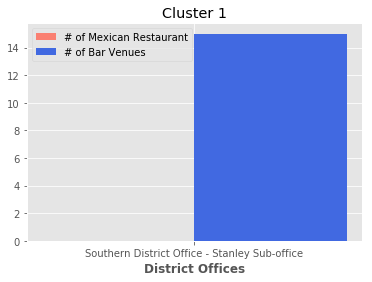

In [289]:
#Number of Mexican Restaurant in Cluster 1 (Bar Graph)
mex_restaurant = cluster_1['# of Mexican Restaurant']
bar_venues = cluster_1['# of Bar Venues']
office = cluster_1['Office Name']

#Set wdith of bar
barwidth = 0.4

r1 = np.arange(len(mex_restaurant))
r2 = [x + barwidth for x in r1]

#Make the plot
plt.figure(figsize=(6,4))
plt.bar(r1, mex_restaurant, color='salmon', width=barwidth, label='# of Mexican Restaurant')
plt.bar(r2, bar_venues, color='royalblue', width=barwidth, label='# of Bar Venues')

#Set labels
plt.xlabel('District Offices', fontweight='bold')
plt.title('Cluster 1')
plt.xticks([(r + (r + barwidth))/2 for r in range(len(mex_restaurant))], cluster_1['Office Name'])


plt.legend()
plt.show()

##### Cluster 2

In [290]:
cluster_2 = hongkong_merged.loc[hongkong_merged['Cluster'] == 1, hongkong_merged.columns[[0] + [2] + list(range(8, hongkong_merged.shape[1]))]]
cluster_2

,Office Name,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,# of Mexican Restaurant,# of Bar Venues
4,Eastern District Office - Shau Kei Wan Sub-office,EASTERN,Chinese Restaurant,Park,Coffee Shop,Japanese Restaurant,Seafood Restaurant,Café,Department Store,Noodle House,0,21
6,Kwun Tong District Office,KWUN TONG,Chinese Restaurant,Coffee Shop,Café,Park,Shopping Mall,Fast Food Restaurant,Cruise Ship,Sushi Restaurant,0,29
8,Tsuen Wan District Office,TSUEN WAN,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Shopping Mall,Cha Chaan Teng,Dessert Shop,Noodle House,Cantonese Restaurant,0,33
12,YUEN LONG DISTRICT OFFICE,YUEN LONG,Chinese Restaurant,Fast Food Restaurant,Noodle House,Dessert Shop,Coffee Shop,Japanese Restaurant,Train Station,Shopping Mall,0,23
13,Sai Kung District Office,SAI KUNG,Chinese Restaurant,Fast Food Restaurant,Shopping Mall,Athletics & Sports,Hong Kong Restaurant,Shanghai Restaurant,Hotel,Coffee Shop,0,11
14,Eastern District Office,EASTERN,Chinese Restaurant,Park,Coffee Shop,Japanese Restaurant,Seafood Restaurant,Café,Department Store,Noodle House,0,21
15,Southern District Office - Wah Kwai Sub-office,SOUTHERN,Coffee Shop,Chinese Restaurant,Park,Fast Food Restaurant,Hotel,Shopping Mall,Cantonese Restaurant,Cha Chaan Teng,1,8
18,Sub-District Liaison Team,KWAI TSING,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Dessert Shop,Cha Chaan Teng,Coffee Shop,Park,Café,0,29
20,Sham Shui Po District Office,SHAM SHUI PO,Chinese Restaurant,Shopping Mall,Noodle House,Dessert Shop,Coffee Shop,Dim Sum Restaurant,Cantonese Restaurant,Cha Chaan Teng,1,50
23,Sha Tin District Office,SHA TIN,Café,Chinese Restaurant,Cantonese Restaurant,Shopping Mall,Coffee Shop,Fast Food Restaurant,Train Station,Hong Kong Restaurant,0,18


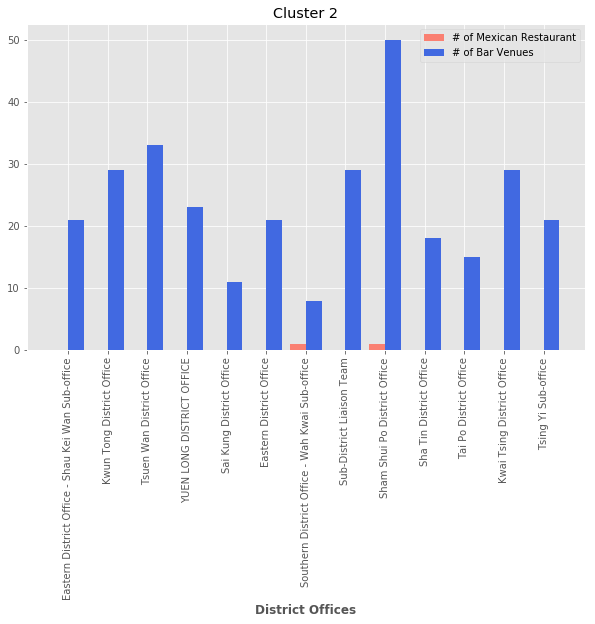

In [291]:
#Number of Mexican Restaurant in Cluster 2 (Bar Graph)
mex_restaurant = cluster_2['# of Mexican Restaurant']
bar_venues = cluster_2['# of Bar Venues']
office = cluster_2['Office Name']

#Set wdith of bar
barwidth = 0.4

r1 = np.arange(len(mex_restaurant))
r2 = [x + barwidth for x in r1]

#Make the plot
plt.figure(figsize=(10,6))
plt.bar(r1, mex_restaurant, color='salmon', width=barwidth, label='# of Mexican Restaurant')
plt.bar(r2, bar_venues, color='royalblue', width=barwidth, label='# of Bar Venues')

#Set labels
plt.xlabel('District Offices', fontweight='bold')
plt.title('Cluster 2')
plt.xticks([(r + (r + barwidth))/2 for r in range(len(mex_restaurant))], cluster_2['Office Name'], rotation='vertical')

plt.legend()
plt.show()

##### Cluster 3

In [292]:
cluster_3 = hongkong_merged.loc[hongkong_merged['Cluster'] == 2, hongkong_merged.columns[[0] + [2] + list(range(8, hongkong_merged.shape[1]))]]
cluster_3

,Office Name,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,# of Mexican Restaurant,# of Bar Venues
7,Office of Building Management Liaison Section ...,CENTRAL AND WESTERN,Coffee Shop,Park,French Restaurant,Supermarket,Japanese Restaurant,Thai Restaurant,Harbor / Marina,Garden,1,48
10,Kowloon City District Office,KOWLOON CITY,Hotel,Coffee Shop,Chinese Restaurant,Café,Japanese Restaurant,Dessert Shop,Thai Restaurant,Toy / Game Store,1,50
11,Kowloon City District Office Public Enquiry Se...,KOWLOON CITY,Hotel,Coffee Shop,Chinese Restaurant,Café,Japanese Restaurant,Dessert Shop,Thai Restaurant,Toy / Game Store,1,50
31,Wong Tai Sin District Office,WONG TAI SIN,Coffee Shop,Dessert Shop,Thai Restaurant,Café,Japanese Restaurant,Park,Fast Food Restaurant,Noodle House,0,26
32,Wong Tai Sin District Office Lower Wong Tai Si...,WONG TAI SIN,Coffee Shop,Dessert Shop,Thai Restaurant,Fast Food Restaurant,Café,Chinese Restaurant,Asian Restaurant,Noodle House,0,26


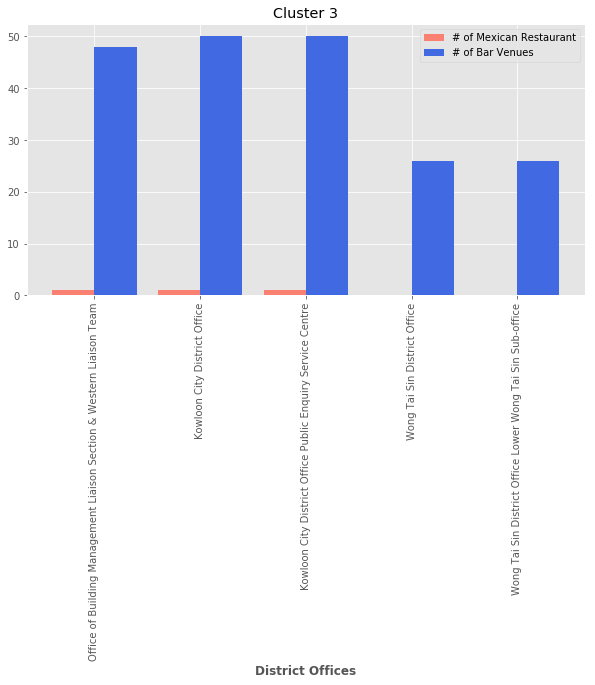

In [293]:
#Number of Mexican Restaurant in Cluster 3 (Bar Graph)
mex_restaurant = cluster_3['# of Mexican Restaurant']
bar_venues = cluster_3['# of Bar Venues']
office = cluster_3['Office Name']

#Set wdith of bar
barwidth = 0.4

r1 = np.arange(len(mex_restaurant))
r2 = [x + barwidth for x in r1]

#Make the plot
plt.figure(figsize=(10,5))
plt.bar(r1, mex_restaurant, color='salmon', width=barwidth, label='# of Mexican Restaurant')
plt.bar(r2, bar_venues, color='royalblue', width=barwidth, label='# of Bar Venues')

#Set labels
plt.xlabel('District Offices', fontweight='bold')
plt.title('Cluster 3')
plt.xticks([(r + (r + barwidth))/2 for r in range(len(mex_restaurant))], cluster_3['Office Name'], rotation='vertical')

plt.legend()
plt.show()

##### Cluster 4

In [294]:
cluster_4 = hongkong_merged.loc[hongkong_merged['Cluster'] == 3, hongkong_merged.columns[[0] + [2] + list(range(8, hongkong_merged.shape[1]))]]
cluster_4

,Office Name,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,# of Mexican Restaurant,# of Bar Venues
2,Eastern District Office - Chai Wan Sub-office,EASTERN,Fast Food Restaurant,Noodle House,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Cha Chaan Teng,Bus Stop,0,4
5,Kwun Tong District Office Shun Lee Sub-office,KWUN TONG,Fast Food Restaurant,Chinese Restaurant,Shopping Mall,Noodle House,Coffee Shop,Bus Stop,Cantonese Restaurant,Cha Chaan Teng,0,19
19,North District Office,NORTH,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Shopping Mall,Park,Gas Station,Bus Station,Noodle House,0,7
24,Ma On Shan Sub-office/Sha Tin District Office,SHA TIN,Shopping Mall,Park,Café,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Dessert Shop,Train Station,0,5
29,Wong Tai Sin District Office Fung Tak Sub-office,WONG TAI SIN,Fast Food Restaurant,Coffee Shop,Thai Restaurant,Chinese Restaurant,Dessert Shop,Park,Hotel,Department Store,0,20
30,Wong Tai Sin District Office Tsz Wan Shan Sub-...,WONG TAI SIN,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Park,Hotel,Shopping Mall,Trail,Noodle House,0,20
34,Leung King Sub-office,TUEN MUN,Fast Food Restaurant,Light Rail Station,Shopping Mall,Multiplex,Cha Chaan Teng,Hong Kong Restaurant,Coffee Shop,Market,0,10
35,Tuen Mun District Office,TUEN MUN,Seafood Restaurant,Light Rail Station,Fast Food Restaurant,Coffee Shop,Shopping Mall,Shanghai Restaurant,Cantonese Restaurant,Multiplex,0,13


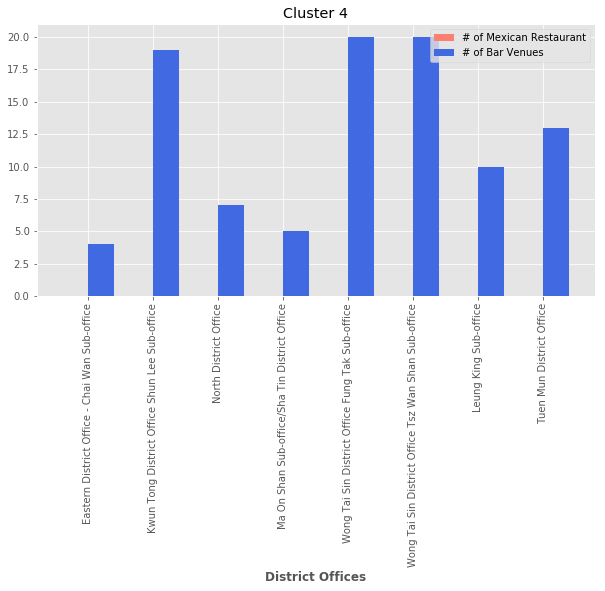

In [295]:
#Number of Mexican Restaurant in Cluster 4 (Bar Graph)
mex_restaurant = cluster_4['# of Mexican Restaurant']
bar_venues = cluster_4['# of Bar Venues']
office = cluster_4['Office Name']

#Set wdith of bar
barwidth = 0.4

r1 = np.arange(len(mex_restaurant))
r2 = [x + barwidth for x in r1]

#Make the plot
plt.figure(figsize=(10,5))
plt.bar(r1, mex_restaurant, color='salmon', width=barwidth, label='# of Mexican Restaurant')
plt.bar(r2, bar_venues, color='royalblue', width=barwidth, label='# of Bar Venues')

#Set labels
plt.xlabel('District Offices', fontweight='bold')
plt.title('Cluster 4')
plt.xticks([(r + (r + barwidth))/2 for r in range(len(mex_restaurant))], cluster_4['Office Name'], rotation='vertical')

plt.legend()
plt.show()

##### Cluster 5

In [296]:
cluster_5 = hongkong_merged.loc[hongkong_merged['Cluster'] == 4, hongkong_merged.columns[[0] + [2] + list(range(8, hongkong_merged.shape[1]))]]
cluster_5

,Office Name,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,# of Mexican Restaurant,# of Bar Venues
33,Butterfly/Wu King Sub-office,TUEN MUN,Seafood Restaurant,Fast Food Restaurant,Shopping Mall,Chinese Restaurant,Cha Chaan Teng,Taiwanese Restaurant,Market,Harbor / Marina,0,2


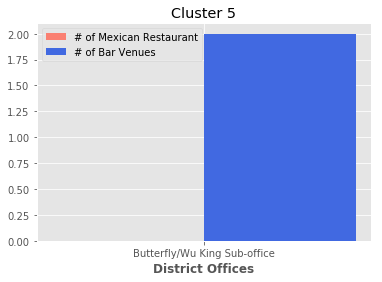

In [297]:
#Number of Mexican Restaurant in Cluster 5 (Bar Graph)
mex_restaurant = cluster_5['# of Mexican Restaurant']
bar_venues = cluster_5['# of Bar Venues']
office = cluster_5['Office Name']

#Set wdith of bar
barwidth = 0.4

r1 = np.arange(len(mex_restaurant))
r2 = [x + barwidth for x in r1]

#Make the plot
plt.figure(figsize=(6, 4))
plt.bar(r1, mex_restaurant, color='salmon', width=barwidth, label='# of Mexican Restaurant')
plt.bar(r2, bar_venues, color='royalblue', width=barwidth, label='# of Bar Venues')

#Set labels
plt.xlabel('District Offices', fontweight='bold')
plt.title('Cluster 5')
plt.xticks([(r + (r + barwidth))/2 for r in range(len(mex_restaurant))], cluster_5['Office Name'])

plt.legend()
plt.show()

##### Cluster 6

In [298]:
cluster_6 = hongkong_merged.loc[hongkong_merged['Cluster'] == 5, hongkong_merged.columns[[0] + [2] + list(range(8, hongkong_merged.shape[1]))]]
cluster_6

,Office Name,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,# of Mexican Restaurant,# of Bar Venues
0,Wan Chai District Office - Sub Office,WAN CHAI,Café,Hotel,Coffee Shop,Cantonese Restaurant,Vietnamese Restaurant,Supermarket,Clothing Store,Burger Joint,4,50
1,Wan Chai District Office,WAN CHAI,Café,Hotel,Cantonese Restaurant,Coffee Shop,Bakery,Japanese Restaurant,Vietnamese Restaurant,Clothing Store,4,50
3,Eastern District Office - Causeway Bay Sub-office,EASTERN,Hotel,Chinese Restaurant,Dessert Shop,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Cha Chaan Teng,Noodle House,4,50
9,"Sai Kung Office, Sai Kung District Office",SAI KUNG,Seafood Restaurant,Thai Restaurant,Café,Chinese Restaurant,BBQ Joint,Pizza Place,Pub,Dessert Shop,1,7
17,Central and Western District Office,CENTRAL AND WESTERN,Japanese Restaurant,Coffee Shop,Café,Hotel,Italian Restaurant,Bakery,Cantonese Restaurant,Restaurant,4,50
21,Southern District Office,SOUTHERN,Theme Park Ride / Attraction,Café,Park,Hotel,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Restaurant,0,7
22,Islands District Office,ISLANDS,Japanese Restaurant,Coffee Shop,Café,Hotel,Italian Restaurant,Bakery,Cantonese Restaurant,Restaurant,4,50
26,Yau Tsim Mong District Office,YAU TSIM MONG,Coffee Shop,Café,Dim Sum Restaurant,Snack Place,Cha Chaan Teng,Noodle House,Malay Restaurant,Chinese Restaurant,0,50


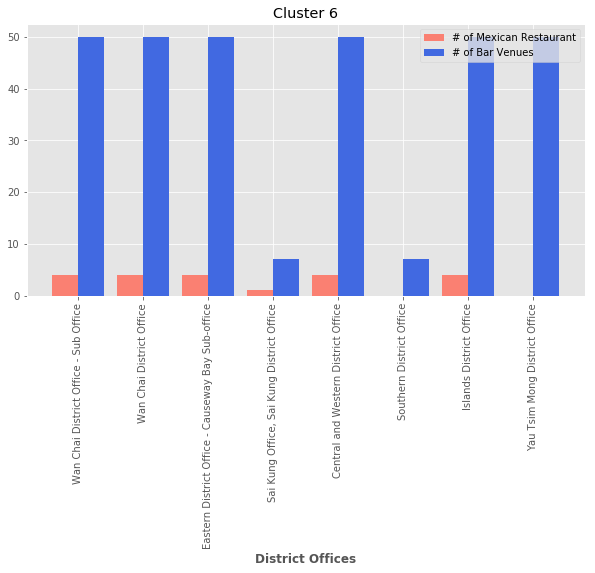

In [299]:
#Number of Mexican Restaurant in Cluster 6 (Bar Graph)
mex_restaurant = cluster_6['# of Mexican Restaurant']
bar_venues = cluster_6['# of Bar Venues']
office = cluster_6['Office Name']

#Set wdith of bar
barwidth = 0.4

r1 = np.arange(len(mex_restaurant))
r2 = [x + barwidth for x in r1]

#Make the plot
plt.figure(figsize=(10,5))
plt.bar(r1, mex_restaurant, color='salmon', width=barwidth, label='# of Mexican Restaurant')
plt.bar(r2, bar_venues, color='royalblue', width=barwidth, label='# of Bar Venues')

#Set labels
plt.xlabel('District Offices', fontweight='bold')
plt.title('Cluster 6')
plt.xticks([(r + (r + barwidth))/2 for r in range(len(mex_restaurant))], cluster_6['Office Name'], rotation='vertical')

plt.legend()
plt.show()

### End of Notebook